In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tess_sip import SIP
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}

In [60]:
tpfs = lk.search_targetpixelfile("WASP50", author="TESS-SPOC").download_all()

[<AxesSubplot:title={'center':'Target ID: 382391899, Cadence: 8807'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
 <AxesSubplot:title={'center':'Target ID: 382391899, Cadence: 132057'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>]

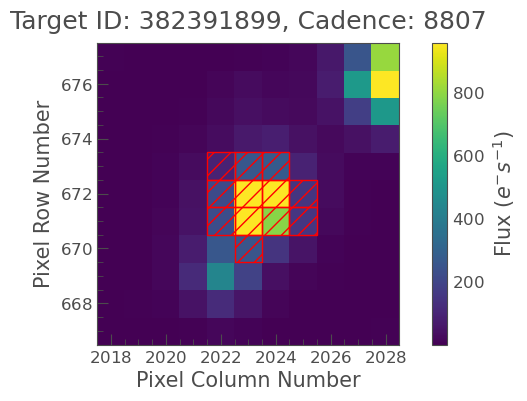

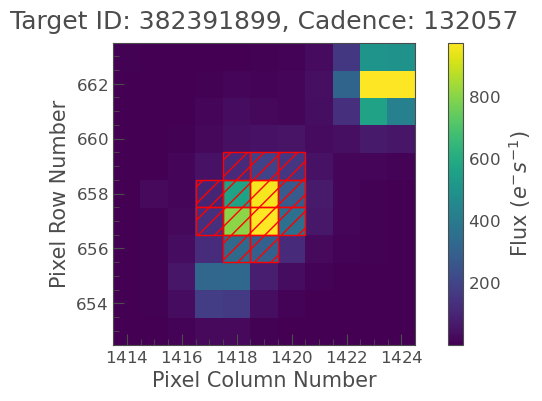

In [67]:
[tpf.plot(aperture_mask="pipeline") for tpf in tpfs]

In [4]:
srs = lk.search_lightcurve("WASP50", author="TESS-SPOC")
display(srs)
lcs = srs.download_all()
#r = SIP(lcs, **sip_kwargs)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
1,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


In [87]:
t, f, f_err = np.genfromtxt(
    "/home/mango/Desktop/WASP50LC_ASASSN_binned.txt",
    unpack=True,
    delimiter=',',
    skip_header=1,
)

In [91]:
data = {
    "time":t,
    "sap_flux":f,
    "sap_flux_err":f_err,
}
lc_ASASSN = lk.LightCurve(data=data)
lc_ASASSN

time,flux,flux_err,sap_flux,sap_flux_err
,,,,
object,float64,float64,float64,float64
6654.8107259650715,nan,nan,-0.0008682310469305676,0.01414213562373095
6674.800516657066,nan,nan,0.002631768953069269,0.02
6887.064640546373,nan,nan,-0.0010348977135977342,0.011547005383792516
6895.05657414797,nan,nan,-0.0030348977135972177,0.011547005383792516
6902.688494404622,nan,nan,0.00196510228640238,0.011547005383792516
6909.476019632304,nan,nan,0.000631768953068601,0.01414213562373095
6921.023825019482,nan,nan,-0.00461823104693071,0.01
6943.5004607709125,nan,nan,-0.0033682310469309584,0.01414213562373095


In [93]:
SIP(lcs)

AttributeError: object has no attribute pipeline_mask

In [36]:
lc = lcs[0].remove_nans().normalize().remove_outliers()

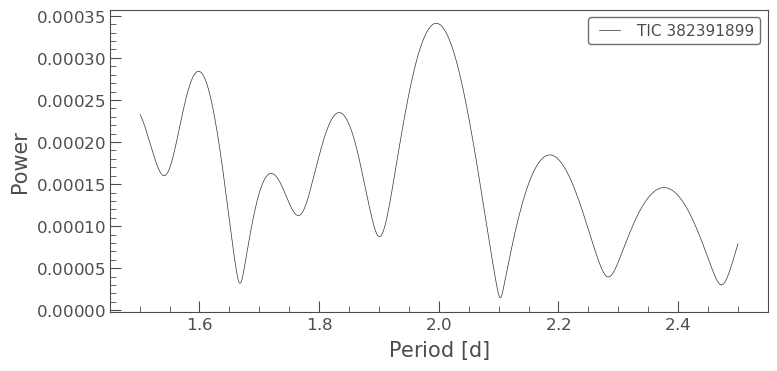

In [52]:
pg = lc.to_periodogram(minimum_period = 1.5,
                      maximum_period = 2.5,
                      oversample_factor=100)
pg.plot(view='period');

In [53]:
new_period = pg.period_at_max_power
new_period

<Quantity 1.99620881 d>

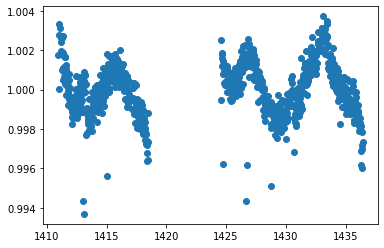

In [39]:
plt.scatter(lc.time.value, lc.flux.value)

In [ ]:
lc_ASASN = lk.LightCurve()